In [2]:
# load shd data
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define a function to load the dataset
def load_shd_data(file_path):
    with h5py.File(file_path, "r") as h5_file:
        spike_times = np.array(h5_file["spikes/times"])
        spike_units = np.array(h5_file["spikes/units"])
        labels = np.array(h5_file["labels"])
    return spike_times, spike_units, labels

# Load SHD training and test data
train_file = "data/SHD/shd_train.h5"
test_file = "data/SHD/shd_test.h5"

train_times, train_units, train_labels = load_shd_data(train_file)
test_times, test_units, test_labels = load_shd_data(test_file)

print(f"Train samples: {len(train_times)}, Test samples: {len(test_times)}")

Train samples: 8156, Test samples: 2264


In [4]:
# convert spike events to features vector
import torch

# Convert spike events into fixed-size feature vectors
def convert_to_feature_vector(spike_times, spike_units, num_neurons=700, time_bins=100):
    # Returns: 1D Tensor of shape (time_bins * num_neurons,)

    spike_tensor = np.zeros((time_bins, num_neurons), dtype=np.float32)

    # Normalize time into the time_bins
    if len(spike_times) > 0:
        time_idx = (spike_times / np.max(spike_times) * (time_bins - 1)).astype(int)
        spike_tensor[time_idx, spike_units] = 1  # Mark neuron firing

    return torch.tensor(spike_tensor.flatten(), dtype=torch.float32)  # Flatten into 1D vector

# Example conversion
example_vector = convert_to_feature_vector(train_times[0], train_units[0])
print("Feature Vector Shape:", example_vector.shape)  # (100 * 700,)

Feature Vector Shape: torch.Size([70000])


In [5]:
# create pytorch dataset
class SHDDataset(Dataset):
    def __init__(self, spike_times, spike_units, labels, num_neurons=700, time_bins=100):
        self.spike_times = spike_times
        self.spike_units = spike_units
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.num_neurons = num_neurons
        self.time_bins = time_bins

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature_vector = convert_to_feature_vector(self.spike_times[idx], self.spike_units[idx], self.num_neurons, self.time_bins)
        return feature_vector, self.labels[idx]

# Create datasets
train_dataset = SHDDataset(train_times, train_units, train_labels)
test_dataset = SHDDataset(test_times, test_units, test_labels)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# define an MLP model (Two hidden layers with ReLU activation, 256 neurons)

import torch.nn as nn

class SHDMLP(nn.Module):
    def __init__(self, input_size=100 * 700, hidden_size=256, output_size=20):
        super(SHDMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (logits for classification)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SHDMLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# training MLP
import matplotlib.pyplot as plt

# Track losses and accuracy for visualization
train_losses, test_losses = [], []
train_accs, test_accs = [], []

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_acc = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accs.append(train_acc)

    # Evaluate on test set
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    test_acc = correct / total
    test_losses.append(total_loss / len(test_loader))
    test_accs.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_acc:.4f}")


Epoch [1/20] - Train Loss: 0.0415, Train Acc: 0.9890 | Test Loss: 1.1666, Test Acc: 0.7774
Epoch [2/20] - Train Loss: 0.0006, Train Acc: 0.9999 | Test Loss: 1.0937, Test Acc: 0.7902
Epoch [3/20] - Train Loss: 0.0002, Train Acc: 1.0000 | Test Loss: 1.1346, Test Acc: 0.7902
Epoch [4/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.1371, Test Acc: 0.7902
Epoch [5/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.1503, Test Acc: 0.7937
Epoch [6/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.1592, Test Acc: 0.7955
Epoch [7/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.1937, Test Acc: 0.7959
Epoch [8/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.2398, Test Acc: 0.7942
Epoch [9/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.2878, Test Acc: 0.7915
Epoch [10/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.3287, Test Acc: 0.7889
Epoch [11/20] - Train Loss: 0.0000, Train Acc: 1.0000 | Test Loss: 1.3525, Test Acc: 0.79

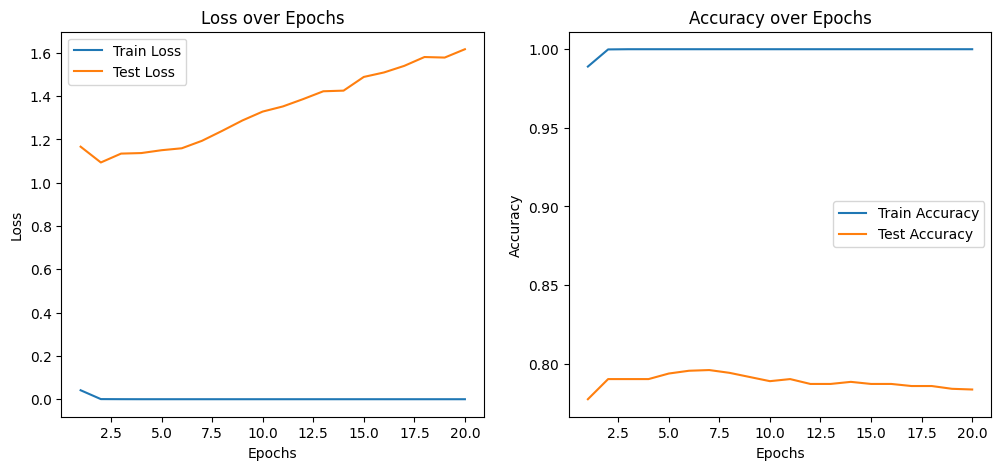

In [9]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.show()